**Load the required data and libraries**

In [1]:
# Libraries  
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings 

warnings.filterwarnings("ignore")

In [2]:
# Data 
df = pd.read_csv("../data/PLP Patient Lifetime Profile.csv", 
                             encoding='UTF-16', delimiter="\t")

appointment_df = pd.read_csv("../data/Appointments List.csv", 
                             encoding='UTF-16', delimiter="\t")

# INTRODUCTION

Following the recent time regression analysis on the trend of appointment count, ......................................

# EXPLANATORY DATA ANALYSIS 
## Data Assessment 

In [3]:
df.head()

,Patient FID,ChartNumber,ZipCode (tmtPLPPatientLifeTimeProfile),CreatedDate,First Date Of Service,Last Date Of Service,Last Primary Appt Type Group,Last Facility City,Days Since Last DoS dim,Next Scheduled Appt Date,...,Total Insurance Payments,Total Patient Payments,Total Writeoff Amount,Charge Code Count,Diagnosis Code Count,Vists / Months Span,OutstandingAR,Count of tmtPLPPatientLifeTimeProfile,SeenProvidersCount,PatientsWithVisit%
0,Grand Total,Total,Total,Total,Total,Total,Total,Total,Total,Total,...,"$1,240,855.95","$14,861,653.28","$995,613.48","8,024","3,473","6,599.64","$1,388,296.81","1,602",0,99.94%
1,5283,1,02139,01/22/18,01/22/18,05/29/18,TMS,CAMBRIDGE,2366,NaN,...,"$6,147.36","$3,464.68","$6,187.96",4,1,12.75,"$6,147.36",1,0,100.00%
2,5286,2,02118,01/23/18,01/16/18,06/27/18,MH Infusion,CAMBRIDGE,2337,NaN,...,NaN,"$4,450.00",NaN,2,1,2.60,$0.00,1,0,100.00%
3,5287,3,02474,01/23/18,01/29/18,02/13/18,MH Infusion,CAMBRIDGE,2471,NaN,...,NaN,"$3,400.00",NaN,2,1,7.00,$0.00,1,0,100.00%
4,5347,5,02127,01/23/18,01/25/18,03/27/18,MH Infusion,CAMBRIDGE,2429,NaN,...,NaN,"$3,900.00",NaN,2,1,4.50,$0.00,1,0,100.00%


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603 entries, 0 to 1602
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Patient FID                             1603 non-null   object
 1   ChartNumber                             1603 non-null   object
 2   ZipCode (tmtPLPPatientLifeTimeProfile)  1603 non-null   object
 3   CreatedDate                             1603 non-null   object
 4   First Date Of Service                   1603 non-null   object
 5   Last Date Of Service                    1603 non-null   object
 6   Last Primary Appt Type Group            1501 non-null   object
 7   Last Facility City                      1469 non-null   object
 8   Days Since Last DoS dim                 1603 non-null   object
 9   Next Scheduled Appt Date                144 non-null    object
 10  Financial Class                         1603 non-null   object
 11  Seen

## Data Wrangling

The data was cleaned to be ready for analysis. This what was done; 

1. **Dropped the first record:** contained irrelevant and incorrect information.
2. **Standardized the appointment status categories:** To make everything consistent, "Made" was changed to "Seen" to get the successfull appointments. The analysis is to involve only the successful appointments. 
3. **Stripped white spaces in chart numbers:** coverted all the chart numbers to integers to enabling cross checking and analysis between the appointment and Patient's lifetime data sets. 
4. **Standardized dates:** the required variables containing dates were converted to a recognized format by python. 

The data was therefore ready for further analysis that involved patients payments over time. More data processing may be performed at convenience

In [5]:
# drop the first row 
df.drop(index=0, inplace=True)
df.reset_index(drop=True, inplace=True)

# Clean the appointment data set 
## Replace "Made" to "Seen"
appointment_df["Appt Status Description"].replace("Made", "Seen", inplace=True)
## Delete the first  and second rows 
appointment_df.drop(index=[0, 1], inplace=True)
appointment_df.reset_index(inplace=True, drop=True)

# Convert chart numbers to integers to deal with white spaces  
## PLP data 
plp_chartnumbers = [int(chart_number) for chart_number in df["ChartNumber"]]
df["ChartNumber"] = plp_chartnumbers

##  Appointment data 
appt_chartnumbers = [int(chart_number) for chart_number in appointment_df["Chartnumber"]]
appointment_df["Chartnumber"] = appt_chartnumbers

# Convert the datetime like variables to datetime 
df["CreatedDate"] = pd.to_datetime(df["CreatedDate"], errors="coerce")
df["First Date Of Service"] = pd.to_datetime(df["First Date Of Service"], errors="coerce")
df["Last Date Of Service"] = pd.to_datetime(df["Last Date Of Service"], errors="coerce")


## Data Analysis and Visualization

**Ideas to be analyzed**

- Split the patients into four categories 
    
    - Ones who had their last day in service before mid-2023 as `patients_before_mid2023`
    - Ones who had their first day of service after mid-2023 as before 2024 `patients_late_2023`
    - Ones who had their services run throughout before through 2024 as `all_time_patients`
    - Ones who had their services run through only in 2024. The reason for this is because according to time series regression the drop of MH infusion gets more steep in 2024. These are the `patients_2024` data set. 

- Analyze what insurance had to offer
- Rate of insurance to what the patient paid
- Analyze the total amount the patient had to pay
- Analyze pay per visit for patients; this is particularly for the successful appointments. 

**Split the patients into four categories**

In [6]:
decided_date = pd.to_datetime("2023-07-01") # mid-2023
begin_2024 = pd.to_datetime("2024-01-01") # begining 2024

# Ones who had their last day in service before mid-2023 as patients_before_mid2023
patients_before_mid2023 = df[df["Last Date Of Service"]<decided_date].reset_index(drop=True)

# Ones who had their first day of service but before 2024
patients_late_2023 = df[(df["First Date Of Service"]>=decided_date)&
                           (df["Last Date Of Service"]<begin_2024)].reset_index(drop=True)

# Special
## Ones who had their first day of service from the beginning of 2024
patients_2024 = df[df["First Date Of Service"]>=begin_2024].reset_index(drop=True)

# Ones who had their services run throughout before through to 2024 as all_time_patients
all_time_patients = df[(df["First Date Of Service"]<decided_date)\
                      &(df["Last Date Of Service"]>=begin_2024)].reset_index(drop=True)

### Insurance Analysis 

In [7]:
# Count the null values (Ratio of null values)
df["Total Insurance Payments"].isna().sum()/len(df)

0.8071161048689138

80% of the insurance data is null therefore this analysis is aborted. Lets focus on the amount paid by each patient

### Payment Analysis

--------**Add more story**-------

**Assumptions**

Here are the assumptions that were made; 

- Every services was charged the same. 
- The cancelled appointments were not invoiced.
- 

In [8]:
# count the null values (ration of null values)
df["Total Patient Payments"].isna().sum()/len(df)

0.031835205992509365

3% of the Patients payment data is null therefore we can go on with the analysis 

In [9]:
# Clean the data 
## Remove the "$" sign
## Deal with the null values 
## Convert the whole variable to numeric 

def clean_amount(amount):
    """
    Docstring 
    Here is how the total payments will be cleaned 
        - Remove the "$" sign
        - Deal with the null values 
        - Convert the whole variable to numeric 
    """
    
    if pd.isnull(amount):
        return None # Handle null values 
    
    # Remove "$" and commas
    amount = amount.replace("$", "").replace(",", "").strip()
    
    return float(amount)

# Test the function
clean_amount(df["Total Patient Payments"][0])

3464.68

In [10]:
# Apply the function to the "Total Patient Payments" column for each category

## ----- Run the below code once
patients_before_mid2023["Total Patient Payments"] = patients_before_mid2023["Total Patient Payments"].apply(clean_amount)
patients_late_2023["Total Patient Payments"] = patients_late_2023["Total Patient Payments"].apply(clean_amount)
all_time_patients["Total Patient Payments"] = all_time_patients["Total Patient Payments"].apply(clean_amount)
patients_2024["Total Patient Payments"] = patients_2024["Total Patient Payments"].apply(clean_amount)

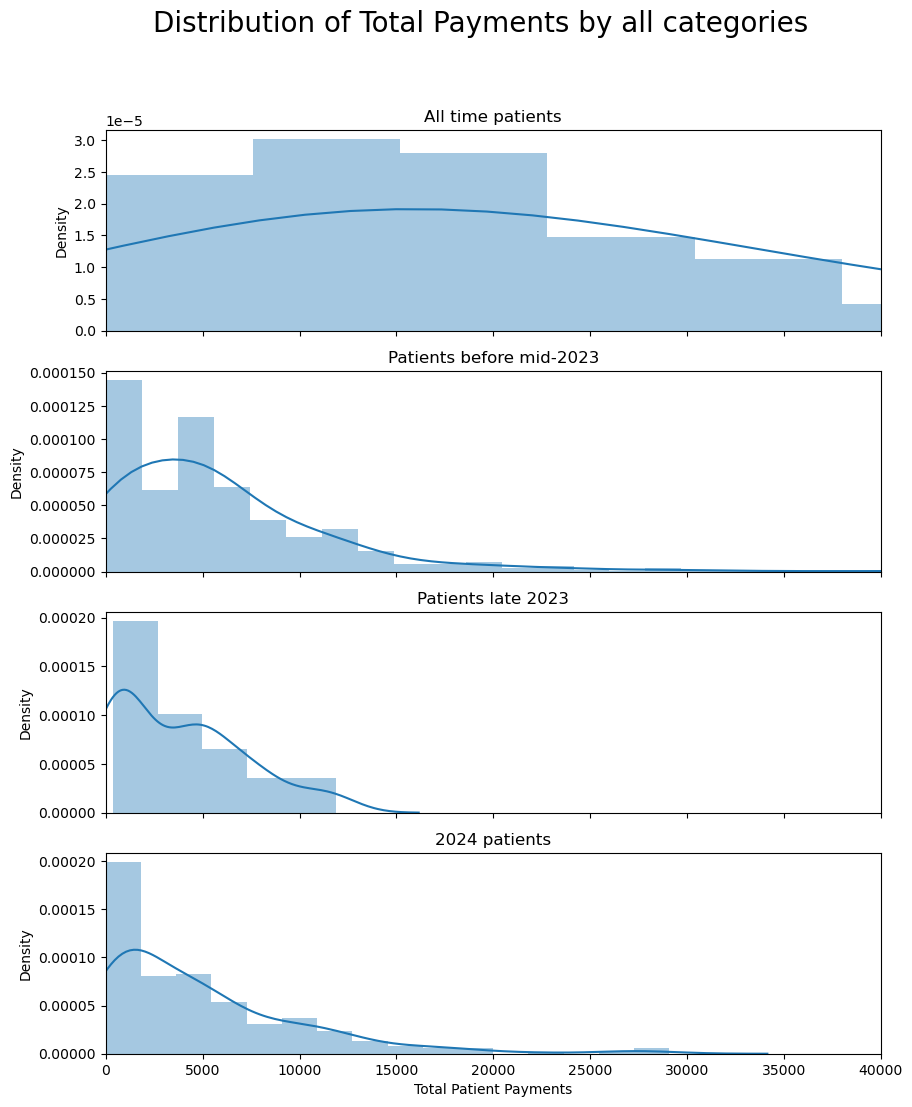

In [11]:
# Distribution of payments 

fig, axes = plt.subplots(nrows=4, ncols=1,
                        figsize=(10, 12), sharex=True)

# Total Patient Payments 
## All time patients 
sns.distplot(all_time_patients["Total Patient Payments"], ax = axes[0])
axes[0].set_title("All time patients")

## Before mid 2023
sns.distplot(patients_before_mid2023["Total Patient Payments"], ax = axes[1])
axes[1].set_title("Patients before mid-2023")

## After mid 2023
sns.distplot(patients_late_2023["Total Patient Payments"], ax = axes[2])
axes[2].set_title("Patients late 2023")

## 2024
sns.distplot(patients_2024["Total Patient Payments"], ax = axes[3])
axes[3].set_title("2024 patients")

plt.xlim(0, 40000)
plt.suptitle("Distribution of Total Payments by all categories", fontsize=20)
plt.show()

The distribution of total patients' payments before and after mid-2023 is almost the same. Patients who went through since before mid 2023 and stopped after mid 2023 generally had higher payments. 

The next step: 
 - Will count the number of successfull appointments for each patient 
 - Calculate the patient's pay per appointment
 - Compute the distribution of the patient's pay per appointment
 
It is assumed that each successfull appointment was priced the same 

**Breakdown to pay per visit**

-------------- Add more story to the data preparation --------

In [12]:
# Prepare the data 
## Get all the successfull appointments 
seen_app_df = appointment_df[appointment_df["Appt Status Description"]=="Seen"].reset_index(drop=True)

## Count the number of appointments per patient 
appointments_per_patient = seen_app_df[["Chartnumber", "Appt Type Group"]].groupby("Chartnumber").count()

appointments_per_patient.reset_index(inplace=True)
appointments_per_patient.rename({"Appt Type Group":"appointment count"}, axis=1, inplace=True)

# Merge with the other PLP data sets and calculate pay per appointment
## Merge with patients before mid-2023
patients_before_mid2023 = patients_before_mid2023.merge(appointments_per_patient,
                                                        left_on="ChartNumber",
                                                        right_on="Chartnumber")
## Calculate pay per visit 
patients_before_mid2023["pay_per_visit"] = patients_before_mid2023["Total Patient Payments"]/\
patients_before_mid2023["appointment count"]

## Merge with patients late 2023
patients_late_2023 = patients_late_2023.merge(appointments_per_patient,
                                                      left_on="ChartNumber",
                                                      right_on="Chartnumber")

## Calculate pay per visit 
patients_late_2023["pay_per_visit"] = patients_late_2023["Total Patient Payments"]/\
patients_late_2023["appointment count"]

## Merge with all time patients 
all_time_patients = all_time_patients.merge(appointments_per_patient,
                                            left_on="ChartNumber",
                                            right_on="Chartnumber")

## Calculate pay per visit 
all_time_patients["pay_per_visit"] = all_time_patients["Total Patient Payments"]/\
all_time_patients["appointment count"]


## Merge with 2024 patients
patients_2024 = patients_2024.merge(appointments_per_patient,
                                    left_on="ChartNumber",
                                    right_on="Chartnumber")

## Calculate pay per visit 
patients_2024["pay_per_visit"] = patients_2024["Total Patient Payments"]/\
patients_2024["appointment count"]

## Remove all records with zero appointments 
patients_before_mid2023 = patients_before_mid2023[patients_before_mid2023["appointment count"]!=0]
patients_late_2023 = patients_late_2023[patients_late_2023["appointment count"]!=0]
all_time_patients = all_time_patients[all_time_patients["appointment count"]!=0]
patients_2024 = patients_2024[patients_2024["appointment count"]!=0]

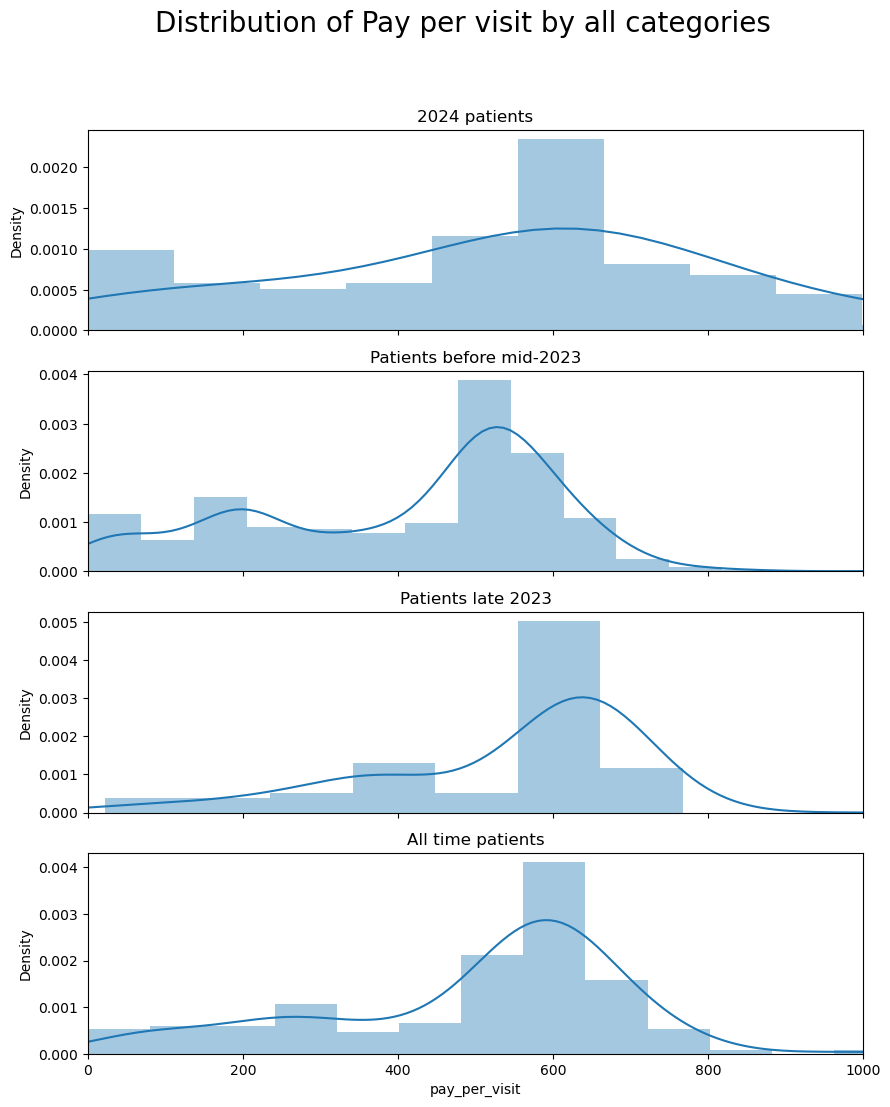

In [13]:
# Calculate the distribution of pay per visit

fig, axes = plt.subplots(nrows=4, ncols=1,
                        figsize=(10, 12), sharex=True)

# Total Patient Payments 
## 2024 patients 
sns.distplot(patients_2024["pay_per_visit"], ax = axes[0])
axes[0].set_title("2024 patients")

## Before mid 2023
sns.distplot(patients_before_mid2023["pay_per_visit"], ax = axes[1])
axes[1].set_title("Patients before mid-2023")

## After mid 2023
sns.distplot(patients_late_2023["pay_per_visit"], ax = axes[2])
axes[2].set_title("Patients late 2023")

## All time patients 
sns.distplot(all_time_patients["pay_per_visit"], ax = axes[3])
axes[3].set_title("All time patients")

plt.xlim(0, 1000)
plt.suptitle("Distribution of Pay per visit by all categories", fontsize=20)
plt.show()

**Check the statistics of pay per visit**

In [14]:
# Compute the summary statistics
d1 = pd.DataFrame(all_time_patients["pay_per_visit"].describe())
d2 = pd.DataFrame(patients_before_mid2023["pay_per_visit"].describe())
d3 = pd.DataFrame(patients_late_2023["pay_per_visit"].describe())
d4 = pd.DataFrame(patients_2024["pay_per_visit"].describe())

# Concatenate the data frames and merge the rows 
d5 = pd.concat([d1, d2, d3, d4], 
               axis=1)
d5.columns = ["all_time", "before mid-2023", "late 2023", "2024"]


# Drop the max and min indices  and the quartiles 
d5.drop(index=['min', '25%', '75%', 'max', 'std'], inplace=True)

# Rename the remaining indices 
d5.index = ['count', 'mean', 'median']

# Show the data set 
d5

,all_time,before mid-2023,late 2023,2024
count,188.000000,846.000000,73.000000,265.000000
mean,499.840100,410.131706,549.336474,624.260872
median,563.397129,487.500000,609.375000,606.250000


<Axes: >

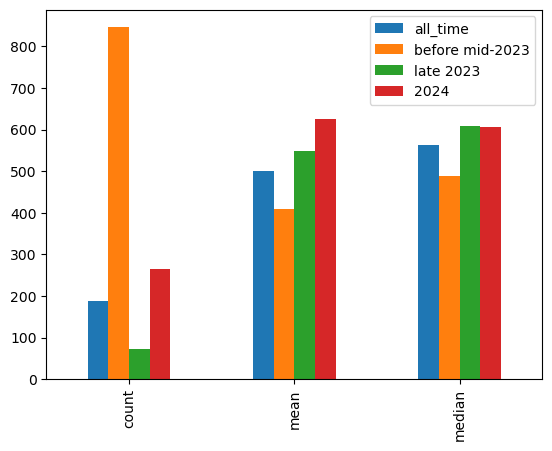

In [15]:
d5.plot(kind="bar")

<Axes: >

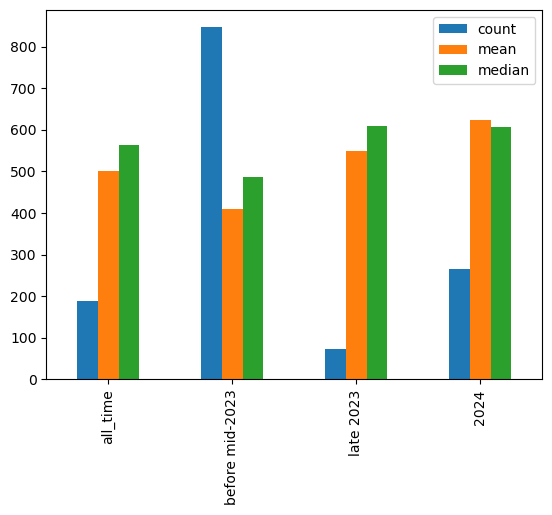

In [16]:
d5.transpose().plot(kind="bar")
# plt.ylim(200, 880)

# CONCLUSION 

This is what I recommend you look into; 

- Are there any extra charges (unseen) to the patients introduced? 
- Is there inflation?
- Did the provision of services became more expensive from your end? 

I also think of looking into the reason why the 263 patients endured the increasing charges. (Maybe there is something special